# Extracting condition-specific trials

The aim of this section is to extract the trials according to the trigger channel. We will explain how the events can be generated from the stimulus channels and how to extract condition specific trials (epochs). Once the trials are extracted, bad epochs will be identified and excluded on based on their peak-to-peak signal amplitude.

## Preparation

Import the relevant Python modules:

In [40]:
import os.path as op
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne_bids import BIDSPath, read_raw_bids

Set the paths for the data and results. Note that these will depend on your local setup.

In [41]:
subject = '01'
session = '01'
task = 'SpAtt'
run = '01'
meg_suffix = 'meg'
ica_suffix = 'ica'
ann_suffix = 'ann'
epo_suffix = 'epo'


preproc_root = r'C:\Users\parkh\MEG Dropbox\Hyojin Park\FLUX\derivatives\Preprocessing'
deriv_root = r'C:\Users\parkh\MEG Dropbox\Hyojin Park\FLUX\derivatives\Analysis'

preproc_root = '/Users/o.jensen@bham.ac.uk/Python/FLUX/Data/ds004346/derivatives/Preprocessing'
deriv_root =   '/Users/o.jensen@bham.ac.uk/Python/FLUX/Data/ds004346/derivatives/Analysis'

bids_path_preproc = BIDSPath(subject=subject, session=session,
            task=task, run=run, suffix=ica_suffix, datatype='meg',
            root=preproc_root, extension='.fif', check=False)

bids_path = BIDSPath(subject=subject, session=session,
            task=task, run=run, suffix=epo_suffix, datatype='meg',
            root=deriv_root, extension='.fif', check=False).mkdir()

ann_fname = bids_path_preproc.basename.replace(ica_suffix, ann_suffix) # output filename
ann_fname = ann_fname.replace('fif', 'csv') # output filename

ann_fname_1 = op.join(bids_path_preproc.directory, ann_fname)
ann_fname_2 = ann_fname_1.replace('run-01', 'run-02')


print(bids_path_preproc.basename, bids_path_preproc.fpath)
print(bids_path.basename, bids_path.fpath)

deriv_file = bids_path.basename.replace('run-01', 'run-12')  # run 12 -> run 01 concatenated with run 02
deriv_fname = op.join(bids_path.directory, deriv_file)
print(deriv_fname)


sub-01_ses-01_task-SpAtt_run-01_ica.fif /Users/o.jensen@bham.ac.uk/Python/FLUX/Data/ds004346/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ica.fif
sub-01_ses-01_task-SpAtt_run-01_epo.fif /Users/o.jensen@bham.ac.uk/Python/FLUX/Data/ds004346/derivatives/Analysis/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_epo.fif
/Users/o.jensen@bham.ac.uk/Python/FLUX/Data/ds004346/derivatives/Analysis/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-12_epo.fif


## Reading the events from the stimulus channels
First read all the events from the stimulus channel (in our case, STI01). We will loop over the 2 fif-files created in the previous step.

In [42]:
# This section only runs on run=01 for illustration purpose 
bids_path_preproc.update(run='01')
raw = read_raw_bids(bids_path=bids_path_preproc, 
            extra_params={'preload':False},
            verbose=True)
               

# Reading the events from the  raw file
events, events_id = mne.events_from_annotations(raw, event_id='auto')

Opening raw data file /Users/o.jensen@bham.ac.uk/Python/FLUX/Data/ds004346/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ica.fif...
    Range : 1665000 ... 3098999 =   1665.000 ...  3098.999 secs
Ready.


/var/folders/n0/w7vb4jpn0nx3hs95f4p7r9br0000gr/T/ipykernel_69341/792396102.py:3: RuntimeWarning: This filename (/Users/o.jensen@bham.ac.uk/Python/FLUX/Data/ds004346/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path_preproc,
/var/folders/n0/w7vb4jpn0nx3hs95f4p7r9br0000gr/T/ipykernel_69341/792396102.py:3: RuntimeWarning: Did not find any events.tsv associated with sub-01_ses-01_task-SpAtt_run-01.

The search_str was "/Users/o.jensen@bham.ac.uk/Python/FLUX/Data/ds004346/derivatives/Preprocessing/sub-01/**/meg/sub-01_ses-01*events.tsv"
  raw = read_raw_bids(bids_path=bids_path_preproc,
/var/folders/n0/w7vb4jpn0nx3hs95f4p7r9br0000gr/T/ipykernel_69341/792396102.py:3: RuntimeWarning: Did not fi

Used Annotations descriptions: ['ITI', 'block_start', 'cue_left', 'cue_right', 'left_resp_maybe', 'right_resp_maybe', 'target_onset', 'trial_end', 'trial_start']


Now read the artifact annocations:

In [43]:
ann1 = mne.read_annotations(ann_fname_1)
print(ann1)
raw.set_annotations(ann1)

<Annotations | 554 segments: BAD_muscle (67), blink (487)>


<Raw | sub-01_ses-01_task-SpAtt_run-01_ica.fif, 343 x 1434000 (1434.0 s), ~557 kB, data not loaded>

The code above extract the events from the trigger channel STI101. This results are represented in the array *events* where the first column is the sample and the third column the corresponding trigger value. Note that the events are concatenated across the 2 subfiles.

To visualize a snippet of the events-array write:

In [44]:
%matplotlib inline
raw.plot(start=50)

Using pyopengl with version 3.1.6


Waiting for Loading-Thread to finish... (max. 10 sec)
Channels marked as bad:
none


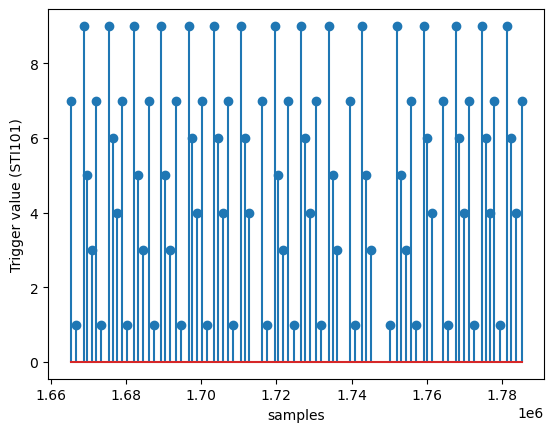

In [45]:
%matplotlib inline
plt.stem(events[:,0][:80], events[:,2][:80])
plt.xlabel('samples')
plt.ylabel('Trigger value (STI101)')
plt.show()

The figures shows an example for part of the events array. The trigger values indicate specific events of the trials. 


## Defining the epochs (trials) according to the event values
Next step is to extract the left and right trials for both subparts of the data:

In [46]:
raw_list = list()
events_list = list()

for subfile in range(1, 3):
    print(subfile)
    if subfile == 1:
        bids_path_preproc.update(run='01')
        ann = mne.read_annotations(ann_fname_1)
     
    if subfile == 2:
        bids_path_preproc.update(run='02')
        ann = mne.read_annotations(ann_fname_2)
    
    raw = read_raw_bids(bids_path=bids_path_preproc, 
            extra_params={'preload':True},
            verbose=True)
    
    events, events_id = mne.events_from_annotations(raw, event_id='auto')
    raw.set_annotations(ann)
                    
    raw_list.append(raw)
    events_list.append(events)
    
# define event ids we are interested in
events_picks_id = {k:v for k, v in events_id.items() if k.startswith('cue')} 

1
Opening raw data file /Users/o.jensen@bham.ac.uk/Python/FLUX/Data/ds004346/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ica.fif...
    Range : 1665000 ... 3098999 =   1665.000 ...  3098.999 secs
Ready.
Reading 0 ... 1433999  =      0.000 ...  1433.999 secs...


/var/folders/n0/w7vb4jpn0nx3hs95f4p7r9br0000gr/T/ipykernel_69341/2543211465.py:14: RuntimeWarning: This filename (/Users/o.jensen@bham.ac.uk/Python/FLUX/Data/ds004346/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path_preproc,


Used Annotations descriptions: ['ITI', 'block_start', 'cue_left', 'cue_right', 'left_resp_maybe', 'right_resp_maybe', 'target_onset', 'trial_end', 'trial_start']
2
Opening raw data file /Users/o.jensen@bham.ac.uk/Python/FLUX/Data/ds004346/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_ica.fif...
    Range : 1665000 ... 3098999 =   1665.000 ...  3098.999 secs
Ready.
Reading 0 ... 1433999  =      0.000 ...  1433.999 secs...


/var/folders/n0/w7vb4jpn0nx3hs95f4p7r9br0000gr/T/ipykernel_69341/2543211465.py:14: RuntimeWarning: Did not find any events.tsv associated with sub-01_ses-01_task-SpAtt_run-01.

The search_str was "/Users/o.jensen@bham.ac.uk/Python/FLUX/Data/ds004346/derivatives/Preprocessing/sub-01/**/meg/sub-01_ses-01*events.tsv"
  raw = read_raw_bids(bids_path=bids_path_preproc,
/var/folders/n0/w7vb4jpn0nx3hs95f4p7r9br0000gr/T/ipykernel_69341/2543211465.py:14: RuntimeWarning: Did not find any channels.tsv associated with sub-01_ses-01_task-SpAtt_run-01.

The search_str was "/Users/o.jensen@bham.ac.uk/Python/FLUX/Data/ds004346/derivatives/Preprocessing/sub-01/**/meg/sub-01_ses-01*channels.tsv"
  raw = read_raw_bids(bids_path=bids_path_preproc,
/var/folders/n0/w7vb4jpn0nx3hs95f4p7r9br0000gr/T/ipykernel_69341/2543211465.py:14: RuntimeWarning: Did not find any meg.json associated with sub-01_ses-01_task-SpAtt_run-01.

The search_str was "/Users/o.jensen@bham.ac.uk/Python/FLUX/Data/ds004346/derivatives/Pr

Used Annotations descriptions: ['ITI', 'block_start', 'cue_left', 'cue_right', 'left_resp_maybe', 'right_resp_maybe', 'target_onset', 'trial_end', 'trial_start']


/var/folders/n0/w7vb4jpn0nx3hs95f4p7r9br0000gr/T/ipykernel_69341/2543211465.py:14: RuntimeWarning: Did not find any events.tsv associated with sub-01_ses-01_task-SpAtt_run-02.

The search_str was "/Users/o.jensen@bham.ac.uk/Python/FLUX/Data/ds004346/derivatives/Preprocessing/sub-01/**/meg/sub-01_ses-01*events.tsv"
  raw = read_raw_bids(bids_path=bids_path_preproc,
/var/folders/n0/w7vb4jpn0nx3hs95f4p7r9br0000gr/T/ipykernel_69341/2543211465.py:14: RuntimeWarning: Did not find any channels.tsv associated with sub-01_ses-01_task-SpAtt_run-02.

The search_str was "/Users/o.jensen@bham.ac.uk/Python/FLUX/Data/ds004346/derivatives/Preprocessing/sub-01/**/meg/sub-01_ses-01*channels.tsv"
  raw = read_raw_bids(bids_path=bids_path_preproc,
/var/folders/n0/w7vb4jpn0nx3hs95f4p7r9br0000gr/T/ipykernel_69341/2543211465.py:14: RuntimeWarning: Did not find any meg.json associated with sub-01_ses-01_task-SpAtt_run-02.

The search_str was "/Users/o.jensen@bham.ac.uk/Python/FLUX/Data/ds004346/derivatives/Pr

Now concatenate raw instances as if they were continuous - i.e combine over the 2 subfiles.

In [47]:
raw, events = mne.concatenate_raws(raw_list, events_list=events_list)
del raw_list 

In [23]:
%matplotlib inline
raw.plot(start=50)

Using qt as 2D backend.
Using pyopengl with version 3.1.6


Channels marked as bad:
none


Set the peak-to-peak amplitude thresholds for trial rejection. These values may change depending on the quality of the data.

In [48]:
reject = dict(grad=5000e-13,  # unit: T / m (gradiometers)
              mag=4e-12,      # unit: T (magnetometers)
              #eeg=40e-6,      # unit: V (EEG channels)
              #eog=250e-6      # unit: V (EOG channels)
             )


We will use time-windows of interest starting 2.5 s prior to the stimulus onset and ending 2 s after. Now perform the epoching using the events and events_id as well as the selected channels:

In [49]:
# Make epochs (4.5 seconds centered on stim onset)

epochs = mne.Epochs(raw,
            events, events_picks_id,
            tmin=-2.5 , tmax=2,
            baseline=None,
            proj=False,
            picks = 'all',
            detrend = 1,
            reject=reject,
            reject_by_annotation=True,
            preload=True,
            verbose=True)

# Show epochs details
epochs

Not setting metadata
344 matching events found
No baseline correction applied
Using data from preloaded Raw for 344 events and 4501 original time points ...
    Rejecting  epoch based on MAG : ['MEG2411', 'MEG2431']
    Rejecting  epoch based on MAG : ['MEG1321']
    Rejecting  epoch based on MAG : ['MEG1331', 'MEG1341']
    Rejecting  epoch based on MAG : ['MEG1321', 'MEG1331']
    Rejecting  epoch based on MAG : ['MEG2421']
    Rejecting  epoch based on MAG : ['MEG1341', 'MEG2411', 'MEG2421', 'MEG2431']
    Rejecting  epoch based on MAG : ['MEG2411', 'MEG2421', 'MEG2431']
    Rejecting  epoch based on MAG : ['MEG1331']
    Rejecting  epoch based on MAG : ['MEG1341']
    Rejecting  epoch based on MAG : ['MEG1331']
    Rejecting  epoch based on MAG : ['MEG2411', 'MEG2431']
    Rejecting  epoch based on MAG : ['MEG1321']
    Rejecting  epoch based on MAG : ['MEG1331', 'MEG1341']
    Rejecting  epoch based on MAG : ['MEG1321', 'MEG1331']
    Rejecting  epoch based on MAG : ['MEG2421']
  

Number of events,266
Events,cue_left: 122cue_right: 144
Time range,-2.500 – 2.000 s
Baseline,off


By calling *epochs* we can check that the number of events is 305 of which 152 are left attention trials and 153 right attention trials. Moreover, we can see that no baseline correction was applied at this stage.

Now we plot an overview of the rejected epochs:

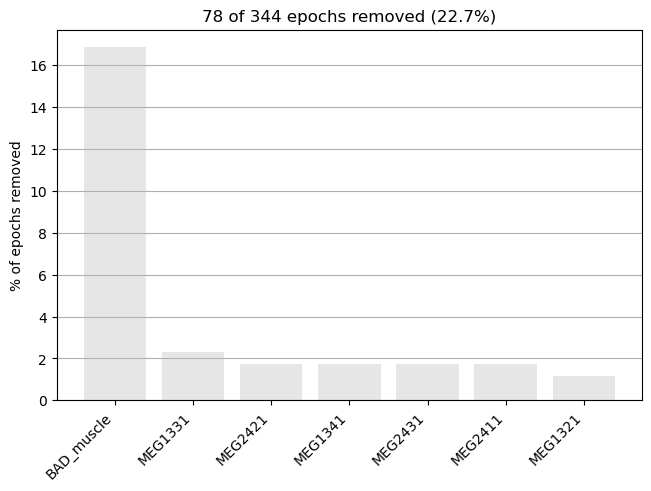

In [50]:
#%matplotlib inline
epochs.plot_drop_log();

A few percent of the trials were rejected due to MEG artifacts in the magnetometers.

Now we save the epoched data in an FIF-file. Note this file will include trials from the 2 subfiles.

In [37]:
print(deriv_fname)

/Users/o.jensen@bham.ac.uk/Python/FLUX/Data/ds004346/derivatives/Analysis/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-12_epo.fif


In [33]:
epochs.save(deriv_fname, overwrite=True)

Overwriting existing file.
Overwriting existing file.


## Plotting the trials
To show the trials for the left-condition for the MEG gradiometers write:

In [34]:
%matplotlib inline
epochs['cue_left'].plot(n_epochs=10, picks=['grad'])

Using pyopengl with version 3.1.6


The plot above shows 10 trials of type left; only gradiometers shown.

To show the trigger (stimulus channels) write:

In [35]:
%matplotlib inline
epochs['cue_left'].plot(n_epochs=1, picks=['stim'])

Using pyopengl with version 3.1.6


An example of the trigger channels for one trial.

Showing the trigger channels is often useful for verifying that correct trials have been selected. Note that STI001 to STI016 denote the individual trigger lines which are 'on' (1) or 'off' (0). The channel STI101 is a combination of the trigger lines ( STI101 = STI001 + 2 * STI002 + 4 * STI003 + 8 * STI004 + ...)

To show all the trials belonging to *left* for a representative gradiometer (MEG2343) use the plot_image function. In the following example we also lowpass filter the indvidual trials at 30 Hz and shorten them (crop) to a -100 to 400 ms interval:

Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 441 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    0.8s
[Parallel(n_job

Not setting metadata
115 matching events found
No baseline correction applied
0 projection items activated


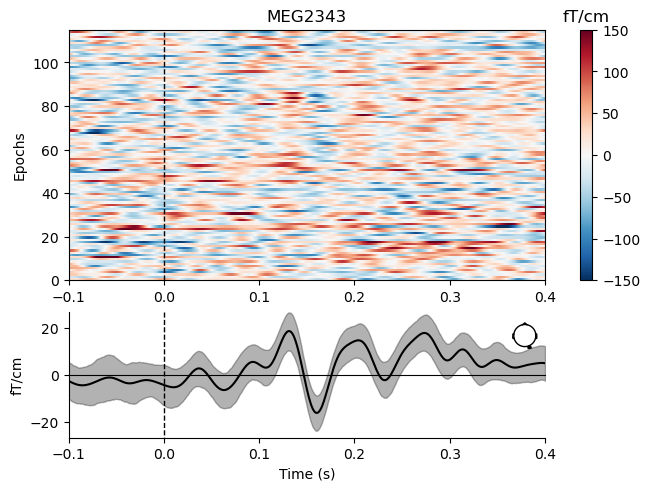

[<Figure size 640x480 with 4 Axes>]

In [36]:
%matplotlib inline
epochs['cue_left'].filter(0.0,30).crop(-0.1,0.4).plot_image(picks=['MEG2343'], vmin=-150, vmax=150)

## Preregistration and publications

Publication, example:

"The data were segmented into intervals of 4.5 s, ranging from 2.5 s prior to stimulus onset and 2 s after. To ensure that no artefacts were missed, trials in which the gradiometers values exceeded 5000 fT/cm or magnetometers exceeded 5000 fT were rejected as well as trials previously annotated with muscle artefacts."
